# Overview

As you might know (or not), NBA is the men's professional basketball league in US. It contains 30 teams located around US and Canada (actually there is only one team in Canada) disputing the national title every year. If you have no idea about what I am saying maybe names such as Michael Jordan, Kobe Bryant, and Stephen Curry could help you. If still it does not sounds familiar this post probably will not be as delight as it is for me, but no problem we can still learn something from here.

The Championship is divided in two phases. First, these 30 teams play against each other during what is called the **regular season**. In the end of the regular season the best 8 teams from each conference (East and West) advance to the **Playoffs** where they dispute to be the Champion.

For my application, I will only focus on the regular season, when every team are playing against each other to go to the Playoffs. During this period each team plays 82 games usually between October and April. Half of the 82 games are palyed at home and the other half is played away. It is very common for teams, during the regular season, have a sequence with more than one game away before playing at home, meaning they have to travel and stay away for more than one game.

For every regular season NBA defines a different calendar with time and location of the games. But this calendar cannot be randomly generate, otherwise we could end up with a very inefficient logistic calendar that would force teams to spend a lot of time and money on unnecessary trips. Moreover, this inefficient calendar could impact on the performance of the players.

Said that, it is plausible to claim that NBA already have an optmized regular season calendar. Where teams will not be playing away for a long period and also the amount of distance is minimized. They have an algorithm that create calendar subject to some constraints.

My point here is to explore the concept of **Genetic Algorithm** to create an efficient NBA calendar. Let's see!!!

# Code

The analysis were performed in R.

In [1]:
library(RCurl)
library(XML)
library(ggmap)
library(dplyr)
library(lubridate)
library(ggrepel)

Loading required package: bitops
Loading required package: ggplot2

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



### Load Necessary Functions
Pre-defined functions that ease the process
* **collectNBACalendar**: Function to gather from internet the NBA calendar for a specific year.
* **earth.dist**: Given latitude and longitude for two points calculate the distance between them.
* **nbaFlightsByTeam**: Returns a data frame with flights and the distance for a specific team during the season.
* **nbaRouteMap**: Plot a map with the route of a team for a calendar

In [2]:
source('NBA season calendar Functions.R')


Attaching package: ‘rvest’

The following object is masked from ‘package:XML’:

    xml



# Data

### Scrapping data from Internet
The data used are not in a well structured data frame. It was necessary to extract the calendar from internet. The function **calendar** is used to extract the nba calendar for an specific season.

Collecting the calendar from https://www.basketball-reference.com

In [3]:
calendar<-collectNBACalendar(2016)

In [4]:
head(calendar)

date,time,visitor,visitor_pts,home,home_pts,season
"Fri, Jan 1, 2016",8:00 pm,New York Knicks,81,Chicago Bulls,108,2016
"Fri, Jan 1, 2016",10:30 pm,Philadelphia 76ers,84,Los Angeles Lakers,93,2016
"Fri, Jan 1, 2016",7:30 pm,Dallas Mavericks,82,Miami Heat,106,2016
"Fri, Jan 1, 2016",7:30 pm,Charlotte Hornets,94,Toronto Raptors,104,2016
"Fri, Jan 1, 2016",7:00 pm,Orlando Magic,91,Washington Wizards,103,2016
"Sat, Jan 2, 2016",3:00 pm,Brooklyn Nets,100,Boston Celtics,97,2016


### Creating date2 variable with date format
**date2** contains the date of the game

In [5]:
calendar$date2<-unlist(lapply(strsplit(gsub(",","",calendar$date)," "),function(x) paste(x[2:4],collapse = "-")))
calendar$date2<-as.Date(calendar$date2,"%b-%d-%Y")
calendar<-calendar%>%
  arrange(date2)

In [6]:
calendar%>%
    filter(complete.cases(.))%>%
    group_by()%>%
    summarise(min(date2),max(date2))

min(date2),max(date2)
2015-10-27,2016-06-19


### Filter Regular Season Games
This calendar contains playoffs games and as I said before we are only interested on regular season games. Therefore, we have to filter the season games.

The 2015-16 season ranged from 10-27-2015 to 04-13-2016 (https://en.wikipedia.org/wiki/2015%E2%80%9316_NBA_season)

In [7]:
calendar<-calendar%>%
            filter(date2<='2016-04-13')

In [8]:
# Quick check: Every team must have 82 games
print(sapply(unique(calendar$home),
       function(x) calendar%>%
  filter((home==x | visitor==x))%>%
  nrow()))

         Atlanta Hawks          Chicago Bulls  Golden State Warriors 
                    82                     82                     82 
        Boston Celtics          Brooklyn Nets        Detroit Pistons 
                    82                     82                     82 
       Houston Rockets     Los Angeles Lakers      Memphis Grizzlies 
                    82                     82                     82 
            Miami Heat        Milwaukee Bucks  Oklahoma City Thunder 
                    82                     82                     82 
         Orlando Magic           Phoenix Suns Portland Trail Blazers 
                    82                     82                     82 
      Sacramento Kings        Toronto Raptors         Indiana Pacers 
                    82                     82                     82 
  Los Angeles Clippers        New York Knicks    Cleveland Cavaliers 
                    82                     82                     82 
        Denver Nugge

### Define Game Location

Based on the name of the home team we can identify the game location. For example, when the home team is 'Chicago Bulls' we know the game was hosted in Chicago.

In a simple example, for a match between 'Chicago Bulls' and 'Memphis Grizzles' where the home team is 'Chicago Bulls' we assume that there was travel from Memphis to Chicago.

In [9]:
calendar$home_location<-unlist(lapply(strsplit(calendar$home," "),function(x) paste(x[1:(length(x)-1)],collapse=" ")))
calendar$visitor_location<-unlist(lapply(strsplit(calendar$visitor," "),function(x) paste(x[1:(length(x)-1)],collapse=" ")))

Even though the code above was able to identify the games location we still had to do some manual adjustments.

For example:
* Golden State -> San Franciso (The team name does not contain the city' name)
* Minnesota -> Minneapolis (The team name contains the state not the city name)

In [10]:
calendar$home_location[calendar$home_location=="Portland Trail"]<-"Portland"
calendar$home_location[calendar$home_location=="Utah"]<-"Salt Lake City"
calendar$home_location[calendar$home_location=="Indiana"]<-"Indianapolis"
calendar$home_location[calendar$home_location=="Minnesota"]<-"Minneapolis"
calendar$home_location[calendar$home_location=="Golden State"]<-"San Francisco"
calendar$home_location[calendar$home_location=="Washington"]<-"Washington D.C."

### Latitude and Longitude for the Cities where the Teams are located
Using the **geocode** function we can download the latitude and longitude using the city name.

In [11]:
#Example for Denver
geocode('Denver')

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Denver&sensor=false


lon,lat
-104.9903,39.73924


In [12]:
# Download every latitude and longitude
cities<-unique(calendar$home_location)
pos<-geocode(cities)
citiesLocation<-data.frame(cities,pos)

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Atlanta&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Chicago&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Boston&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Brooklyn&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Detroit&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Houston&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Los%20Angeles&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Memphis&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?addre

In [13]:
head(citiesLocation)

cities,lon,lat
Atlanta,-84.38798,33.74900
Chicago,-87.62980,41.87811
San Francisco,-122.41942,37.77493
Boston,-71.05888,42.36008
Brooklyn,-73.94416,40.67818
Detroit,-83.04575,42.33143


### Calculate the Distance between Teams based on their Latitude and Longitude

Using the locations (latitude and longitude) it is possible to calculate the distance between any two cities.

In [14]:
# Every combination between two teams
distance<-expand.grid(unique(calendar$home_location),unique(calendar$home_location))
names(distance)<-c("team1","team2")

# Join the location (latitude and longitude) for each team.
distance<-merge(x=distance,
                y=citiesLocation,
                by.x="team1",
                by.y="cities",
                all.x=TRUE)
names(distance)[3:4]<-c("lon1","lat1")

distance<-merge(x=distance,
                y=citiesLocation,
                by.x="team2",
                by.y="cities",
                all.x=TRUE)
names(distance)[5:6]<-c("lon2","lat2")

In [15]:
head(distance)

team2,team1,lon1,lat1,lon2,lat2
Atlanta,Atlanta,-84.38798,33.74900,-84.38798,33.749
Atlanta,New York,-74.00597,40.71278,-84.38798,33.749
Atlanta,Phoenix,-112.07404,33.44838,-84.38798,33.749
Atlanta,Denver,-104.99025,39.73924,-84.38798,33.749
Atlanta,San Antonio,-98.49363,29.42412,-84.38798,33.749
Atlanta,Milwaukee,-87.90647,43.03890,-84.38798,33.749


Calculate the distance (km) between two cities using the function **earth.dist**.

In [16]:
distance$distanceKM<-apply(distance[,names(distance)%in%c('lon1','lat1','lon2','lat2')],1,function(x) earth.dist(x[1],x[2],x[3],x[4],R=6378.145))

In [17]:
head(distance)

team2,team1,lon1,lat1,lon2,lat2,distanceKM
Atlanta,Atlanta,-84.38798,33.74900,-84.38798,33.749,0.000
Atlanta,New York,-74.00597,40.71278,-84.38798,33.749,1201.662
Atlanta,Phoenix,-112.07404,33.44838,-84.38798,33.749,2559.549
Atlanta,Denver,-104.99025,39.73924,-84.38798,33.749,1949.539
Atlanta,San Antonio,-98.49363,29.42412,-84.38798,33.749,1420.095
Atlanta,Milwaukee,-87.90647,43.03890,-84.38798,33.749,1078.468


### Function to calculate Distance traveled by a Team during the season

The **nbaFlightsByTeam** function returns a data frame with the flights and the distance for a specific team during the season.

For example for the **Philadelphia 76ers**

In [18]:
PHI_flights<-nbaFlightsByTeam(calendar,"Philadelphia 76ers",date=TRUE)

In [19]:
head(PHI_flights)

flight_from,flight_to,distance
Philadelphia,Boston,436.1181
Boston,Philadelphia,436.1181
Philadelphia,Philadelphia,0.0000
Philadelphia,Milwaukee,1115.2003
Milwaukee,Cleveland,539.5069
Cleveland,Philadelphia,576.9254


The first 6 games of **Phildelphia 76ers** are:

**Away(A)**-**Home(H)**-**H**-**A**-**A**-**H**

The **Phildelphia 76ers** plays its first game at Boston and goes back home to play the next two games. Then they fly to Milwaukee and after that they go to Cleveland before coming back home for another game.

### Philadelphia 76ers Travel Map

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=united+states&zoom=4&size=640x640&scale=2&maptype=terrain&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=united%20states&sensor=false
Map from URL : http://tile.stamen.com/toner-lite/4/2/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/3/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/4/4.png
Map from URL : http://tile.stamen.com/toner-lite/4/2/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/3/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/4/5.png
Map from URL : http://tile.stamen.com/toner-lite/4/2/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/3/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/4/6.png
Map from URL : http://tile.stamen.com/toner-lite/4/2/7.png
Map from URL : http://tile.stamen.com/toner-lite/4/3/7.png
Map from URL : http://tile.stamen.com/toner-lite/4/4/7.png
Warning message:
“`panel.margin` is deprecat

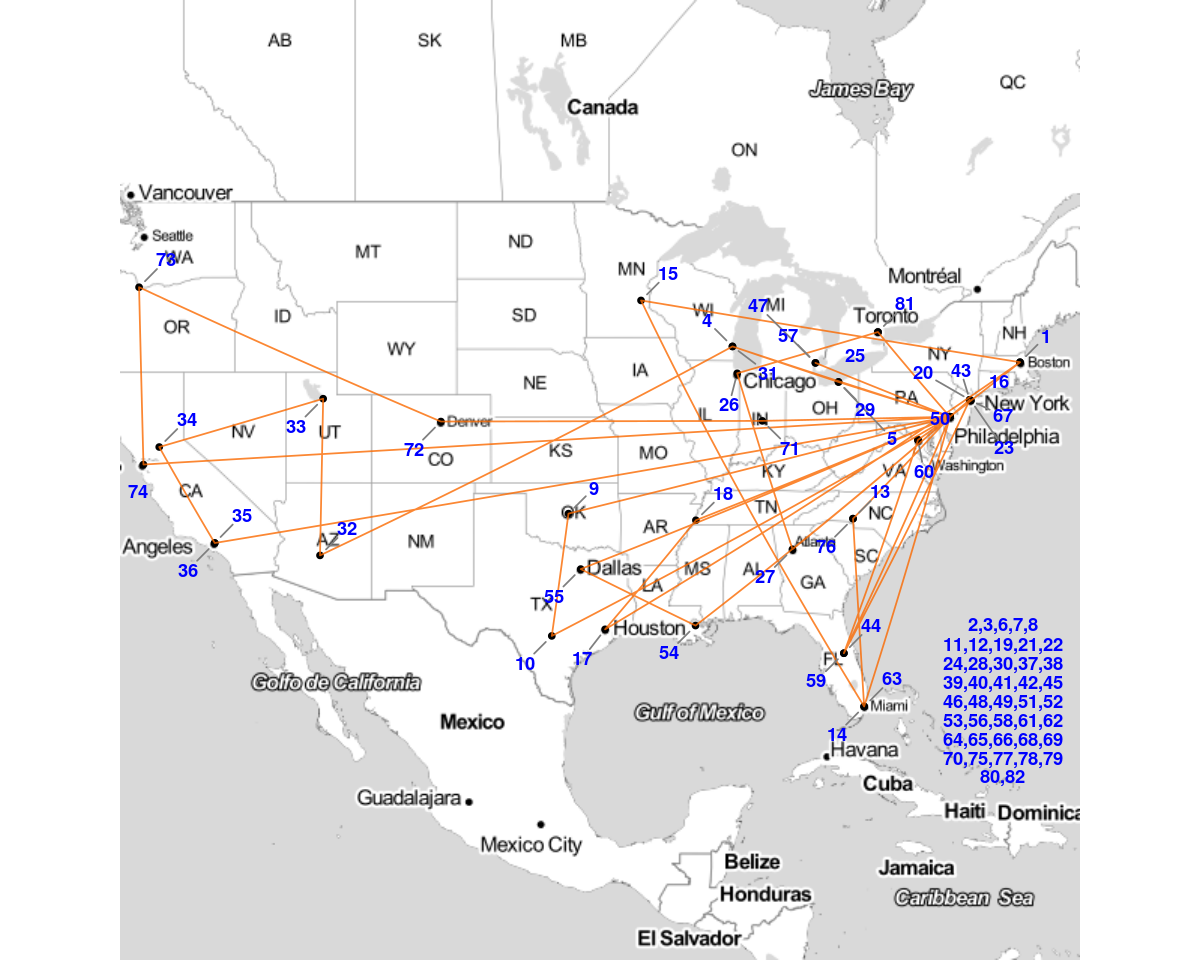

In [20]:
options(repr.plot.width=10, repr.plot.height=8)
nbaRouteMap(calendar,"Philadelphia 76ers")

The blue numbers on the map represent the order of the games. The concentration of number on the bottom right are the home games.

To get the total kilometers traveled by the **Philadelphia 76ers** during the 2015-16 regular season we just have to sum the variable distance.

In [21]:
cat(format(sum(PHI_flights$distance),big.mark=",",scientific=FALSE),"km")

62,334.6 km

### Total distance traveled by team during 2015-16 season

In [22]:
teams<-unique(calendar$home)
total_distance_by_team<-sapply(teams,function(x) sum(nbaFlightsByTeam(calendar,x)$distance))

In [23]:
total_distance_by_team<-as.data.frame(total_distance_by_team[order(total_distance_by_team,decreasing=TRUE)])
total_distance_by_team$team<-rownames(total_distance_by_team)
rownames(total_distance_by_team)<-NULL
colnames(total_distance_by_team)<-c('distance','team')
total_distance_by_team<-total_distance_by_team[c(2,1)]

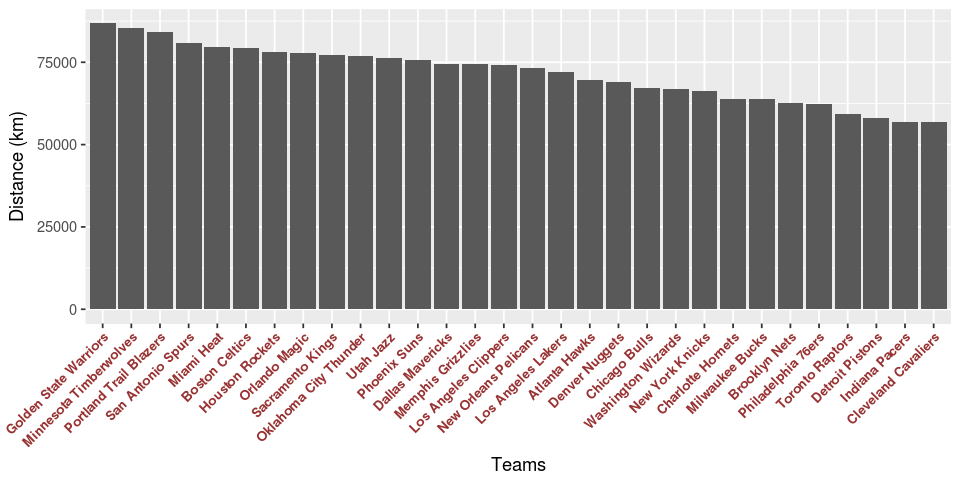

In [24]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(total_distance_by_team,aes(x=reorder(team,-distance),distance))+
geom_bar(stat = "identity")+
labs(x="Teams")+
labs(y="Distance (km)")+
 theme(axis.text.x = element_text(face="bold", color="#993333", 
                           size=8, angle=45, hjust=1))

Interesting to see that both team that made NBA final are on the extrems. Coincidence?!? Yes, there is no correlation :P

### Total distance traveled

If we sum the distance traveled by every team we have the total distance traveled during the season.

In [25]:
cat(format(sum(total_distance_by_team$distance),big.mark=",",scientific=FALSE),"km")

2,149,348 km

### Propose a new calendar

If we shuffle the orders of the lines from the original calendar we can create a new calendar.

In [26]:
randomCalendar <- calendar[sample(nrow(calendar),replace=FALSE),]

Now, the first 10 games for Philadelphia 76ers using this new calendar would be:

In [32]:
randomCalendar%>%
select(home,visitor)%>%
filter(home=="Philadelphia 76ers" | visitor=="Philadelphia 76ers")%>%
head()

home,visitor
Philadelphia 76ers,Chicago Bulls
Minnesota Timberwolves,Philadelphia 76ers
Philadelphia 76ers,Atlanta Hawks
Philadelphia 76ers,Washington Wizards
Detroit Pistons,Philadelphia 76ers
Denver Nuggets,Philadelphia 76ers


As you can see the total distance traveled by Philadelphia 76ers with this calendar has increased.

In [58]:
cat("Original Calendar:\t",
    format(sum(nbaFlightsByTeam(calendar,"Philadelphia 76ers",date=FALSE)$distance),big.mark=",",scientific=FALSE),
    "\nRandom Calendar:\t",format(sum(nbaFlightsByTeam(randomCalendar,"Philadelphia 76ers",date=FALSE)$distance),big.mark=",",scientific=FALSE))

Original Calendar:	 62,334.61 
Random Calendar:	 102,711.7

Total distance traveled also has increased.

In [63]:
cat("Original Calendar:\t",
    format(sum(sapply(teams,function(x) sum(nbaFlightsByTeam(calendar,x,date=FALSE)$distance))),big.mark=",",scientific=FALSE),
        "\nCandidate Calendar:\t",
        format(sum(sapply(teams,function(x) sum(nbaFlightsByTeam(randomCalendar,x,date=FALSE)$distance))),big.mark=",",scientific=FALSE)
            )

Original Calendar:	 2,149,348 
Candidate Calendar:	 3,137,937

### Would be able to create a new calendar a with low distance traveled.

As I wrote in the begining of the post I believe it is hard to improve the original NBA calendar, but still we can try to create a new calendar with a resonable solution.

Let's create 1,000 random calendars and check the distribution of the total distance traveled.

In [39]:
result<-rep(NA,1000)
for(i in 1:length(result)){
    c_<-calendar[sample(nrow(calendar),replace=FALSE),]
    result[i]<-sum(sapply(teams,function(x) sum(nbaFlightsByTeam(c_,x,date=FALSE)$distance)))
}

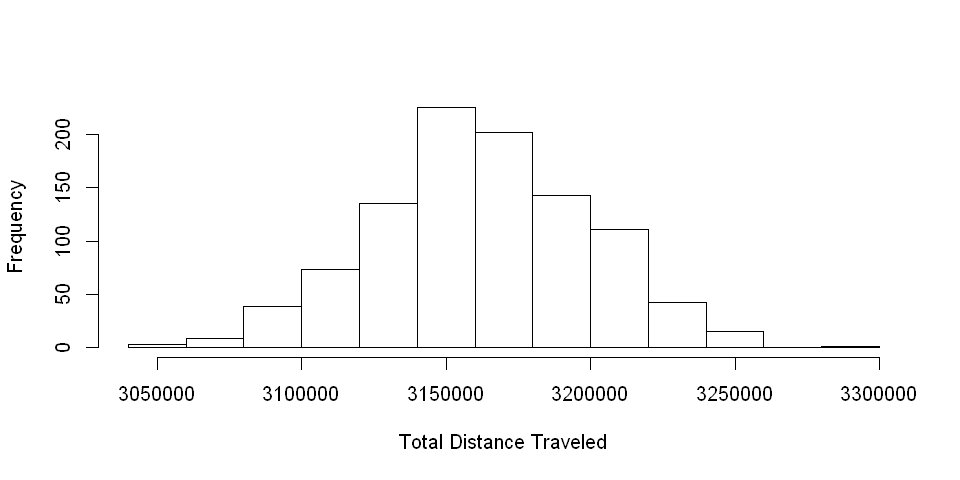

In [82]:
hist(result,main="",xlab="Total Distance Traveled")

As you can see, find the calendar with a very low distance traveled is not an easy task. We randomly generated 1,000 calendar and the minimum result was not even close to the original calendar

In [81]:
min(result)

[1] 3050827

Is there a way to create a calendar with as low total distanca traveled as the original?

The answer is YES... Of course, the NBA came up with this then there is an alternative. 

### Genetic Algorithm